# 1. Blocker Fraud Company
 <font size="2"> Dados e problema negócio hipotéticos</font>
 
A Blocker Fraud Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas atravś de dispositivos móveis.

O modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso da detecção de fraude das transações.

## 1.1. Estratégia de expansão

A Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.

Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

## 1.2. Objetivo

Criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

### 1.2.1. Entregáveis

Modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?


# 2. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2.1. Utils functions

# 3. Data

## 3.1. Load dataset

In [4]:
df = pd.read_parquet('df_applied_features.parquet.gzip') 

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,is_high_amount,is_M_customer,is_new_balance_orig_zero,is_new_balance_dest_zero,diff_orig,diff_dest,is_orig_old_balance_greater_new,is_dest_old_balance_greater_new
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0,0,1,0,1,9839.64000,0.00000,1,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0,0,1,0,1,1864.28000,0.00000,1,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0,0,0,1,1,181.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0,0,0,1,1,181.00000,21182.00000,1,1
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0,0,1,0,1,11668.14000,0.00000,1,0


# 4. Data preparation

## 4.1. Change types

In [6]:
cols_to_include = ['isFlaggedFraud', 'is_high_amount', 'is_M_customer', 
                   'is_new_balance_orig_zero', 'is_orig_old_balance_greater_new',
                   'is_new_balance_dest_zero', 'is_dest_old_balance_greater_new']
for col in cols_to_include:
    df[col] = df[col].astype('category')

## 4.2. Numericals

In [7]:
numerical = [var for var in df.columns if df[var].dtype!='O' and df[var].dtype!='category']

### 4.2.1. Discretes

In [8]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(df[var].unique()) < 100 and var not in ['step', 'isFraud']:
        print(var, ' values: ', df[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))


There are 0 discrete variables


### 4.2.2. Continuous

In [9]:
# find continuous variables
numerical = [var for var in numerical if var not in discrete and var not in ['step', 'isFraud']]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 7 numerical and continuous variables


As variáveis númericas podemos definir que, não temos variáveis discretas, aquelas que tem uma quantidade menor que 100 valores únicos, portanto são todas variáveis númericas contínuas.

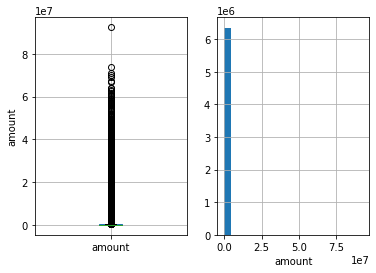

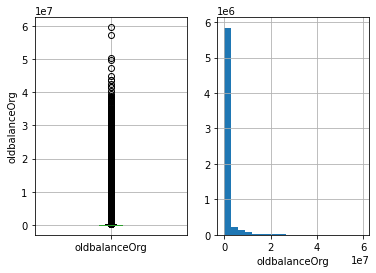

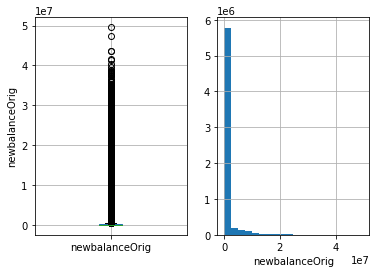

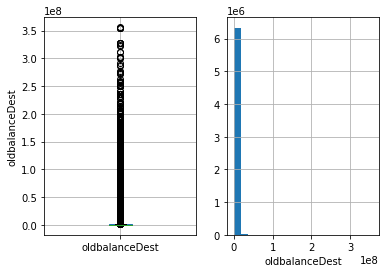

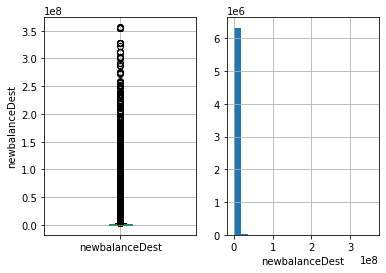

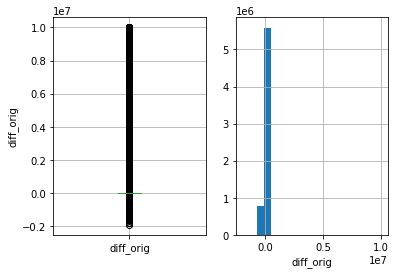

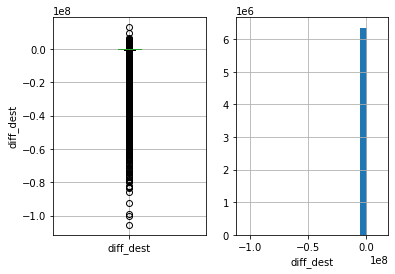

In [10]:
for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_xlabel(var)

    plt.show()

Como vimos na seção de análise exploratória, todas as variáveis contém outliers e também temos que elas não seguem uma distribuição normal.

## 4.3. Categoricals

In [11]:
# find categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O' or df[var].dtype=='category']

print('There are {} categorical variables'.format(len(categorical)))

There are 10 categorical variables


Text(0, 0.5, 'Number of different categories')

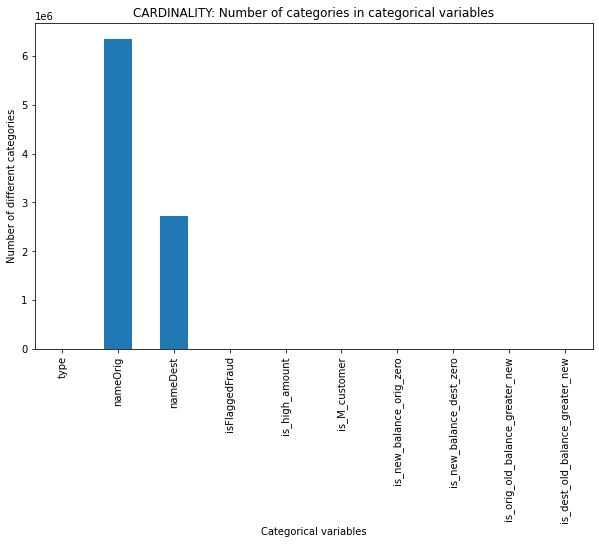

In [12]:
# plot number of categories per categorical variable

df[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Temos duas variáveis que tem uma altíssima cardinalidade, porém essa variáveis são identificadores dos clientes, vamos retirar essas duas para verificar as outras.

Text(0, 0.5, 'Number of different categories')

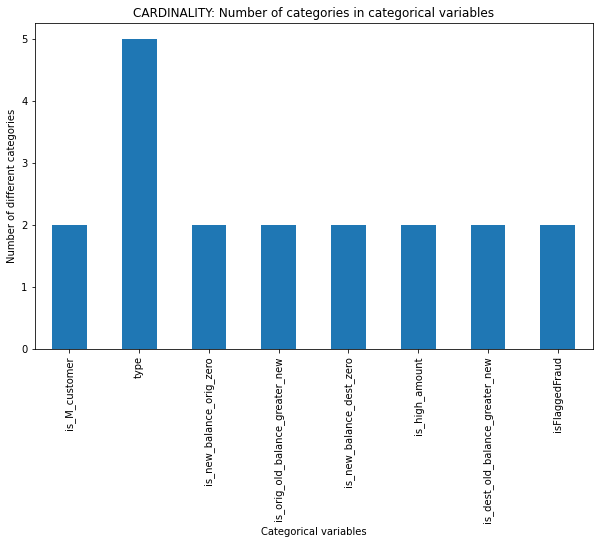

In [13]:
new_categorical = list(set(categorical) - set(['nameOrig', 'nameDest']))

df[new_categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

As variáveis restante possuem poucos valores únicos, portanto pouca cardinalidade e isso é bom sinal. Bem possível que essas features contém valores raros, são aqueles valores pouco comum nos dados.

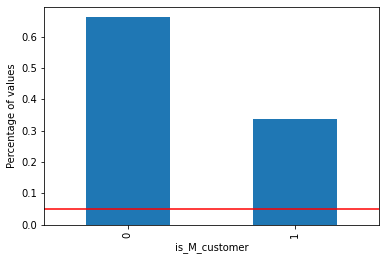

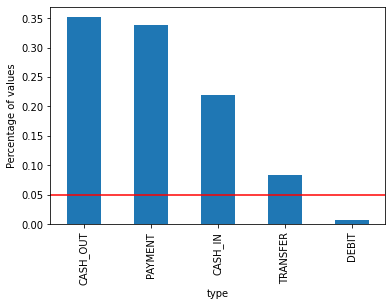

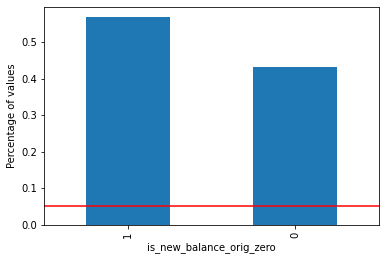

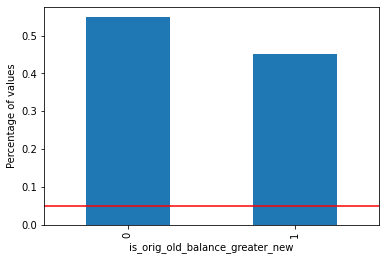

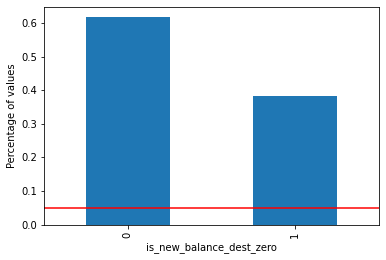

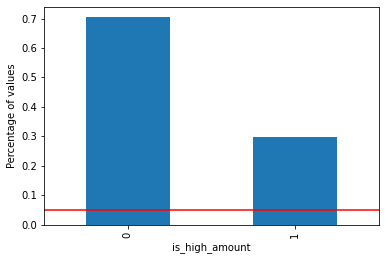

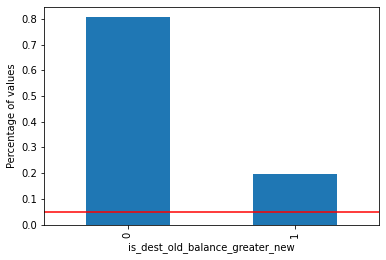

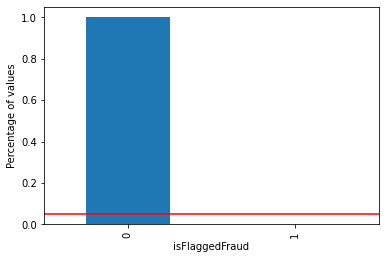

In [14]:
total_houses = len(df)
for col in new_categorical:
    temp_df = pd.Series(df[col].value_counts() / total_houses)

    # Make plot with these percentages.
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # Add a line at 5 % to flag the threshold for rare categories.
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of values')
    plt.show()

Definido um limite de 5% na divisão de raro ou não, somente as variáveis type e isFlaggedFraud possuem dados raros.

## 4.4. Conclusion

Para os dados númericos iremos atuar como a discretisation, que é o processo de transformar variáveis contínuas em discretas criando intervalos contíguos que espalha os intervalos dos valores das variáveis, criando assim uma variável mais normal.

Além disso, também trataremos as variáveis categóricas, algumas serão transformadas em raras auxiliando o modelo.